# Curve decoding

Analysis to see if you can decode left vs right turns from individual units in M2.



For each curve ROI we get all the times the mouse crosses it and the associated firing rate (as a function of position relative to the axis).
Then for each unit we use a logistic regression model to try and decode if the mouse went left/right through the curve from the firing rates alone. 



In [1]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from fcutils.progress import track
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from fcutils.plot.figure import clean_axes
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths.signals import rolling_mean
from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts, curves, get_roi_crossings

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Writings\THESIS\Chpt4\Plots")

# print all available recordings
TARGET = "CUN/PPN"
print(get_recording_names(region=TARGET))

[2022-07-19 10:21:41,198][INFO]: Connecting root@127.0.0.1:3306
[2022-07-19 10:21:41,274][INFO]: Connected root@127.0.0.1:3306


[07/19/22 10:21:41] DEBUG    Connected to database: LOCOMOTION4                ]8;id=349924;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py\__init__.py]8;;\:]8;id=63271;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py#11\11]8;;\

['FC_210715_AAA1110750_r5_hairpin' 'FC_210716_AAA1110750_r6_hairpin'
 'FC_210720_AAA1110750_hairpin' 'FC_210721_AAA1110750_hairpin'
 'FC_210722_AAA1110750_hairpin' 'FC_211022_BAA110516_hairpin'
 'FC_211027_BAA110516_hairpin' 'FC_211214_BAA110517_hairpin'
 'FC_220114_BAA110517_hairpin' 'FC_220117_BAA110517_hairpin'
 'FC_220119_BAA110517_hairpin' 'FC_220120_BAA110517_hairpin'
 'FC_210917_BAA1110279_hairpin' 'FC_210820_BAA1110281_hairpin'
 'FC_210829_BAA1110281_hairpin' 'FC_210830_BAA1110281_hairpin'
 'FC_210831_BAA1110281_hairpin' 'FC_210901_BAA1110281_hairpin'
 'FC_210906_BAA1110281_hairpin' 'FC_210917_BAA1110281_hairpin']


In [2]:
def frate(spikes, s, bins):
    """
        Given the s position at each frame and the frame at which spikes occurred during a ROI crossing,
        get firing rate wrt position relative to the apex.
    """
    
    n_visits_per_bin = np.histogram(s, bins=bins)[0]

    spikes_positions = [s[spike] for spike in spikes]
    nspikes_per_bin = np.histogram(spikes_positions, bins=bins)[0]

    spikes_positions = rolling_mean(spikes_positions, 5)
    nspikes_per_bin = rolling_mean(nspikes_per_bin, 5)

    frates = nspikes_per_bin / n_visits_per_bin * 60
    frates[np.isnan(frates)] = 0.0
    frates[np.isinf(frates)] = 0.0  # a spike but no frame count?
    return frates

In [3]:
ds = 2
bins = np.arange(-20, 20+ds, step=ds)


data = {
    **dict(
        name=[],  # recording name
        unit_id=[],  # unit id
        brainregion=[],  # brain region
        direction=[],  # direction (out/in)
        roi = [],  # ROI name
        label=[],  # left, right or straight
    ),
    **{s:[] for s in bins[1:]}  # firing rate at each S position bin
}


In [4]:
alldata = {}
for REC in track(get_recording_names(region=TARGET)):
    # fetch recording data
    
    alldata[REC] =  get_data(REC)

Output()

[07/19/22 10:21:49] INFO     Got 46 units for FC_210715_AAA1110750_r5_hairpin    ]8;id=180742;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=435733;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:21:54] INFO     Got 41 units for FC_210716_AAA1110750_r6_hairpin    ]8;id=686953;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=209654;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:22:39] INFO     Got 26 units for FC_210720_AAA1110750_hairpin       ]8;id=272477;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=353621;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:22:53] INFO     Got 0 units for FC_210721_AAA1110750_hairpin        ]8;id=872279;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=9203;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:23:06] INFO     Got 28 units for FC_210722_AAA1110750_hairpin       ]8;id=452538;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=108072;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:23:10] INFO     Got 28 units for FC_211022_BAA110516_hairpin        ]8;id=509121;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=204963;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:24:11] INFO     Got 23 units for FC_211027_BAA110516_hairpin        ]8;id=290633;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=109288;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:24:29] INFO     Got 52 units for FC_211214_BAA110517_hairpin        ]8;id=532603;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=851591;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:24:49] INFO     Got 37 units for FC_220114_BAA110517_hairpin        ]8;id=126970;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=360092;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:24:54] INFO     Got 41 units for FC_220117_BAA110517_hairpin        ]8;id=105397;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=637615;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:24:59] INFO     Got 58 units for FC_220119_BAA110517_hairpin        ]8;id=775108;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=354010;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:25:05] INFO     Got 56 units for FC_220120_BAA110517_hairpin        ]8;id=650602;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=644857;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:25:17] INFO     Got 7 units for FC_210917_BAA1110279_hairpin        ]8;id=447811;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=219282;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:25:21] INFO     Got 83 units for FC_210820_BAA1110281_hairpin       ]8;id=765825;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=852135;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:25:25] INFO     Got 65 units for FC_210829_BAA1110281_hairpin       ]8;id=820644;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=265240;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:25:43] INFO     Got 50 units for FC_210830_BAA1110281_hairpin       ]8;id=254761;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=497173;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:26:08] INFO     Got 92 units for FC_210831_BAA1110281_hairpin       ]8;id=249137;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=53541;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:26:45] INFO     Got 0 units for FC_210901_BAA1110281_hairpin        ]8;id=632483;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=223009;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:27:02] INFO     Got 61 units for FC_210906_BAA1110281_hairpin       ]8;id=790389;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=592128;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 10:27:30] INFO     Got 25 units for FC_210917_BAA1110281_hairpin       ]8;id=663959;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=789630;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

In [5]:
curve_direction = dict(
    first=dict(out="right", _in="left"),
    second=dict(out="right", _in="left"),
    third=dict(out="left", _in="right"),
    fourth=dict(out="left", _in="right"),
)


for REC in get_recording_names(region=TARGET):
    # fetch recording data
    # units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    units, left_fl, right_fl, left_hl, right_hl, body = alldata[REC]

    if units is None or not len(units):
        continue
    
    if TARGET == "MOs":
        units = units.loc[units.brain_region.isin(["MOs", "MOs1", "MOs2/3", "MOs5", "MOs6a", "MOs6b"])]
    else:
        units = units.loc[units.brain_region.isin(["CUN", "PPN"])]
        

    out_bouts     = get_session_bouts(REC, complete=None)
    in_bouts      = get_session_bouts(REC, direction="inbound", complete=None)
    out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
    in_crossings  = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

    for (i, unit) in units.iterrows():
        for curve in ("second", "third", "fourth"):
            for (direction, crossings, bouts) in (("out", out_crossings[curve], out_bouts), ("_in", in_crossings[curve], in_bouts)):
                sign = 1 if direction == "out" else -1

                for i, cross in crossings.iterrows():

                    # get spikes at each bin
                    bout = bouts.iloc[cross.bout_idx]
                    s = sign * (curves[curve].s - np.array(bout.s[cross.enter_frame:cross.exit_frame]))
                    spikes = unit.spikes[(unit.spikes > cross.session_start_frame)&(unit.spikes < cross.session_end_frame)] - cross.session_start_frame

                    # get firing rate
                    cross_frate = frate(spikes, s, bins)

                    # store all data
                    data["name"].append(REC)
                    data["unit_id"].append(unit.unit_id)
                    data["brainregion"].append(unit.brain_region)
                    data["direction"].append(direction)
                    data["roi"].append(curve)
                    data["label"].append(curve_direction[curve][direction])
                    for i, bin in enumerate(bins[1:]):
                        data[bin].append(cross_frate[i])


data = pd.DataFrame(data)
data.head()

[07/19/22 10:27:38] INFO     Got 31 bouts for FC_210715_AAA1110750_r5_hairpin |  ]8;id=365604;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=588610;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

[07/19/22 10:27:39] INFO     Got 29 bouts for FC_210715_AAA1110750_r5_hairpin |  ]8;id=580627;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=456771;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | inbound                                                  

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:27:41] INFO     Got 26 bouts for FC_210716_AAA1110750_r6_hairpin |  ]8;id=655536;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=140815;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

[07/19/22 10:27:42] INFO     Got 17 bouts for FC_210716_AAA1110750_r6_hairpin |  ]8;id=444456;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=977560;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | inbound                                                  

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:27:44] INFO     Got 60 bouts for FC_210720_AAA1110750_hairpin |     ]8;id=107470;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=739057;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

[07/19/22 10:27:45] INFO     Got 59 bouts for FC_210720_AAA1110750_hairpin |     ]8;id=562736;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=752334;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | inbound                                                  

[07/19/22 10:27:46] INFO     Got 17 bouts for FC_210722_AAA1110750_hairpin |     ]8;id=930807;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=964553;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

[07/19/22 10:27:47] INFO     Got 22 bouts for FC_210722_AAA1110750_hairpin |     ]8;id=643504;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=778591;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | inbound                                                  

[07/19/22 10:27:48] INFO     Got 51 bouts for FC_211022_BAA110516_hairpin | None ]8;id=72474;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=358536;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

[07/19/22 10:27:49] INFO     Got 40 bouts for FC_211022_BAA110516_hairpin | None ]8;id=24116;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=237690;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:27:51] INFO     Got 43 bouts for FC_211027_BAA110516_hairpin | None ]8;id=496439;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=809695;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

[07/19/22 10:27:52] INFO     Got 27 bouts for FC_211027_BAA110516_hairpin | None ]8;id=48171;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=6044;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

[07/19/22 10:27:53] INFO     Got 38 bouts for FC_211214_BAA110517_hairpin | None ]8;id=578580;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=720246;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

[07/19/22 10:27:54] INFO     Got 51 bouts for FC_211214_BAA110517_hairpin | None ]8;id=798498;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=499349;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

[07/19/22 10:27:55] INFO     Got 23 bouts for FC_220114_BAA110517_hairpin | None ]8;id=744768;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=125180;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

                    INFO     Got 17 bouts for FC_220114_BAA110517_hairpin | None ]8;id=257411;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=253455;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

[07/19/22 10:27:56] INFO     Got 9 bouts for FC_220117_BAA110517_hairpin | None  ]8;id=750188;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=409113;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

                    INFO     Got 4 bouts for FC_220117_BAA110517_hairpin | None  ]8;id=86456;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=57932;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


                    INFO     Got 15 bouts for FC_220119_BAA110517_hairpin | None ]8;id=6519;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=877880;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

                    INFO     Got 5 bouts for FC_220119_BAA110517_hairpin | None  ]8;id=259486;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=224524;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:27:57] INFO     Got 7 bouts for FC_220120_BAA110517_hairpin | None  ]8;id=28648;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=950820;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

[07/19/22 10:27:58] INFO     Got 14 bouts for FC_220120_BAA110517_hairpin | None ]8;id=603763;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=216862;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


                    INFO     Got 19 bouts for FC_210917_BAA1110279_hairpin |     ]8;id=847554;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=38828;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

                    INFO     Got 7 bouts for FC_210917_BAA1110279_hairpin | None ]8;id=24824;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=422569;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

                    INFO     Got 4 bouts for FC_210820_BAA1110281_hairpin | None ]8;id=696237;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=156228;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

                    INFO     Got 1 bouts for FC_210820_BAA1110281_hairpin | None ]8;id=231500;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=873816;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:27:59] INFO     Got 9 bouts for FC_210829_BAA1110281_hairpin | None ]8;id=48914;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=604883;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

                    INFO     Got 3 bouts for FC_210829_BAA1110281_hairpin | None ]8;id=92358;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=581202;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:28:00] INFO     Got 63 bouts for FC_210830_BAA1110281_hairpin |     ]8;id=892712;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=490896;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

[07/19/22 10:28:01] INFO     Got 35 bouts for FC_210830_BAA1110281_hairpin |     ]8;id=63425;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=171678;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | inbound                                                  

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:28:04] INFO     Got 54 bouts for FC_210831_BAA1110281_hairpin |     ]8;id=860534;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=990267;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

[07/19/22 10:28:05] INFO     Got 29 bouts for FC_210831_BAA1110281_hairpin |     ]8;id=979933;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=127068;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | inbound                                                  

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:28:11] INFO     Got 29 bouts for FC_210906_BAA1110281_hairpin |     ]8;id=244920;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=252492;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | outbound                                                 

                    INFO     Got 25 bouts for FC_210906_BAA1110281_hairpin |     ]8;id=530690;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=131371;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             None | inbound                                                  

c:\Users\Federico\.conda\envs\glm\lib\site-packages\fcutils\maths\signals.py:126: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X = pd.Series(X)


[07/19/22 10:28:13] INFO     Got 0 bouts for FC_210917_BAA1110281_hairpin | None ]8;id=215698;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=482929;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | outbound                                                      

                    INFO     Got 0 bouts for FC_210917_BAA1110281_hairpin | None ]8;id=735421;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=968555;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             | inbound                                                       

,name,unit_id,brainregion,direction,roi,label,-18,-16,-14,-12,...,2,4,6,8,10,12,14,16,18,20
0,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,6.0,10.000000,3.75,...,42.0,18.0,28.000000,16.000000,16.000000,16.000000,8.0,4.0,8.0,9.0
1,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,30.0,20.0,13.333333,7.50,...,4.0,4.0,4.000000,4.000000,3.000000,0.000000,0.0,0.0,4.0,4.0
2,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,0.0,13.333333,12.00,...,4.0,4.0,4.000000,8.000000,18.000000,12.000000,12.0,12.0,4.0,0.0
3,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,60.0,40.0,26.666667,18.75,...,20.0,12.0,8.000000,4.000000,4.000000,8.000000,8.0,12.0,12.0,12.0
4,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,0.0,6.666667,10.00,...,9.6,8.0,8.571429,10.285714,6.666667,6.461538,14.4,16.0,12.0,16.0


In [6]:
# label each row by the unit/recording it belongs to
data["identifier"] = data["name"] + "+unit_" + data["unit_id"].astype(str)
n_units = len(data.identifier.unique())
print(n_units)

172


## Fit model
For each unit, try to predict L/R turn from the firing rate of the unit.

In [7]:
# create dummy variables columns
data = data.join(pd.get_dummies(data[["label", "direction"]]))
data.head()

,name,unit_id,brainregion,direction,roi,label,-18,-16,-14,-12,...,12,14,16,18,20,identifier,label_left,label_right,direction__in,direction_out
0,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,6.0,10.000000,3.75,...,16.000000,8.0,4.0,8.0,9.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
1,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,30.0,20.0,13.333333,7.50,...,0.000000,0.0,0.0,4.0,4.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
2,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,0.0,13.333333,12.00,...,12.000000,12.0,12.0,4.0,0.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
3,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,60.0,40.0,26.666667,18.75,...,8.000000,8.0,12.0,12.0,12.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1
4,FC_210715_AAA1110750_r5_hairpin,833,CUN,out,second,right,0.0,0.0,6.666667,10.00,...,6.461538,14.4,16.0,12.0,16.0,FC_210715_AAA1110750_r5_hairpin+unit_833,0,1,0,1


In [23]:
PREDICTED = "label_right"

select_cols = list(bins[1:]) + [PREDICTED]

results, shuffled_accuracies = {}, []

for unit in track(data.identifier.unique()):
    # sample L/R trials to get equal number of trials per direction
    unit_data = data.loc[data.identifier == unit]
    name = unit_data.name.iloc[0]
    # if name in tuned_recs:  # if not exists run the kinematics analysis cells
    #     continue
    
    side_counts = unit_data.groupby(["label"])["name"].count()

    try:
        n_selected = min(side_counts["left"], side_counts["right"])
    except:
        continue
    
    if n_selected < 5:
        continue
    
    left = unit_data.loc[unit_data.label == "left"].sample(n_selected)
    right = unit_data.loc[unit_data.label == "right"].sample(n_selected)

    # keep bins + label column
    unit_data = pd.concat([left, right])[select_cols].reset_index(drop=True)

    # split train/test
    X = unit_data.drop(PREDICTED, axis=1)
    y = unit_data[PREDICTED]

    # standardize columns of X
    X = (X - X.mean()) / (X.std() + 0.0001)


    # fit the model with 5x k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    kf.get_n_splits(X)
    kf_accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fit model
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)
        kf_accuracies.append(logreg.score(X_test, y_test))


    # fit model on randomly shuffled labels
    # split X in train/test
    X_train, X_test, _, _ = train_test_split(X, y, test_size=.3, random_state=0)
    unit_shuffled_accuracies = []
    for i in range(100):
        y_shuffled = y.sample(frac=1, random_state=i)
        _, _, y_shuff_train, y_shuff_test = train_test_split(X, y_shuffled, test_size=0.3, random_state=0)

        shuffled_logreg = LogisticRegression()
        shuffled_logreg.fit(X_train, y_shuff_train)

        acc = shuffled_logreg.score(X_test, y_shuff_test)
        shuffled_accuracies.append(acc)
        unit_shuffled_accuracies.append(acc)

    # check if the model is significantly better than the shuffled labels
    tuned = np.mean(kf_accuracies) > np.percentile(unit_shuffled_accuracies, 99)

    results[unit] = dict(
        name=name,
        identifier=unit,
        model=logreg,
        accuracy=np.mean(kf_accuracies),
        tuned = tuned,
        X_test=X_test,
        y_test=y_test,

    )


print(f"Succesfully fit {len(results.keys())} models for {n_units}")

Output()

Succesfully fit 89 models for 172


# Plot results
plot accuracy histograma and ROC curve

<Figure size 1152x648 with 2 Axes>

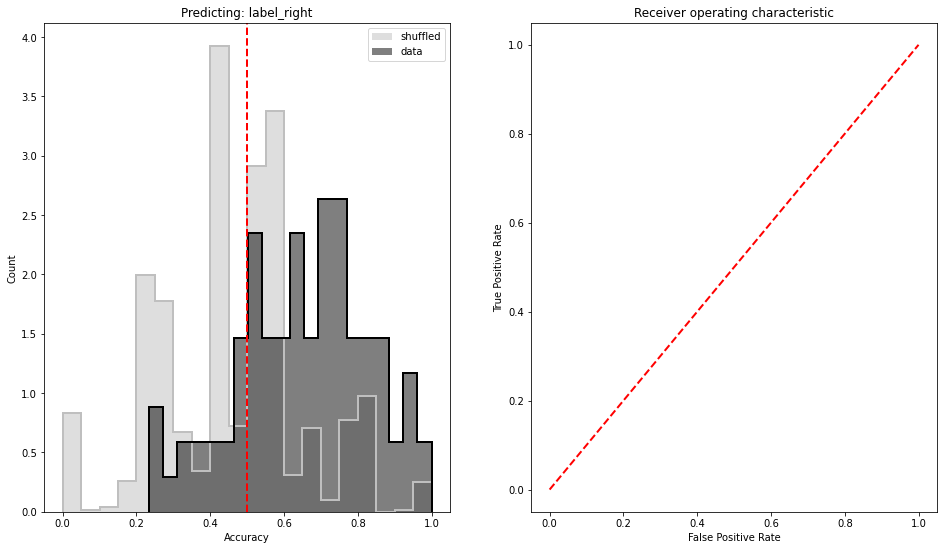

In [24]:
TARGET = TARGET if TARGET == "MOs" else "CUN_PPN"

f, axes = plt.subplots(1, 2, figsize=(16, 9))

accuracies = [r["accuracy"] for r in results.values()]

axes[0].hist(shuffled_accuracies, density=True, bins=20, alpha=.5, color=[.75, .75, .75], label="shuffled")
axes[0].hist(shuffled_accuracies, density=True, bins=20, lw=2, histtype="step", color=[.75, .75, .75])
axes[0].hist(accuracies, density=True, bins=20, alpha=.5, color="k", label="data")
axes[0].hist(accuracies, density=True, bins=20, lw=2, histtype="step", color="k")
axes[0].legend()

# for res in results.values():
#     logit_roc_auc = roc_auc_score(res['y_test'], logreg.predict(res['X_test']))
#     fpr, tpr, thresholds = roc_curve(res['y_test'], logreg.predict_proba(res['X_test'])[:,1])

#     axes[1].plot(fpr, tpr, color="k", alpha=.5)

axes[0].set(xlabel="Accuracy", ylabel="Count", title=f"Predicting: {PREDICTED}", xlim=[-0.05, 1.05])
axes[0].axvline(0.5, lw=2, color="r", ls="--")
axes[1].plot([0, 1], [0, 1],'r--', lw=2)
_ = axes[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver operating characteristic')

# save figure
f.savefig(save_folder / f"LR_decoding_{TARGET}_accuracy_hist.svg")

In [25]:
accuracies = np.array(accuracies)
above_66 = len(accuracies[accuracies >= 0.6])
above_90 = len(accuracies[accuracies >= 0.9])
print(f"{above_66}/{len(accuracies)} ({round(above_66/len(accuracies) * 100, 2)}%) units have accuracy > 60%")
print(f"{above_90}/{len(accuracies)} ({round(above_90/len(accuracies) * 100, 2)}%) units have accuracy > 90%")

56/89 (62.92%) units have accuracy > 60%
8/89 (8.99%) units have accuracy > 90%


Fraction tuned: 0.11235955056179775 - 10/89


<Figure size 1152x648 with 1 Axes>

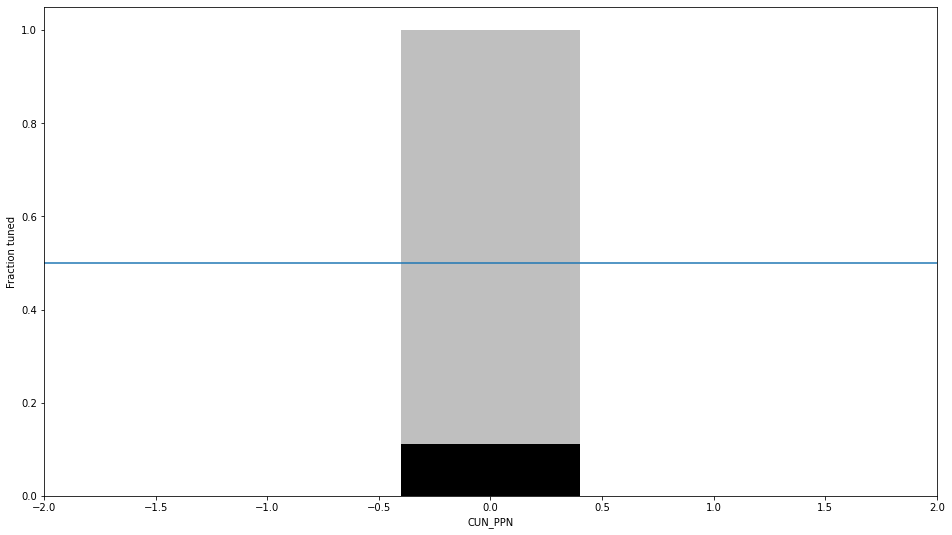

In [26]:
# Plot number of tuned units as bar plot
f, ax = plt.subplots(1, 1, figsize=(16, 9))

N = len(results.keys())
n_tuned = len([r for r in results.values() if r["tuned"]])

print(f"Fraction tuned: {n_tuned/N} - {n_tuned}/{N}")

ax.bar(0, n_tuned/N, color="k")
ax.bar(0, (N - n_tuned)/N, bottom=(n_tuned)/N, color=[.75, .75, .75])
_ = ax.set(xlim=[-2, 2], ylabel="Fraction tuned", xlabel=TARGET)
ax.axhline(.5)


f.savefig(save_folder / f"LR_decoding_{TARGET}_n_tuned.svg")

<Figure size 1152x648 with 1 Axes>

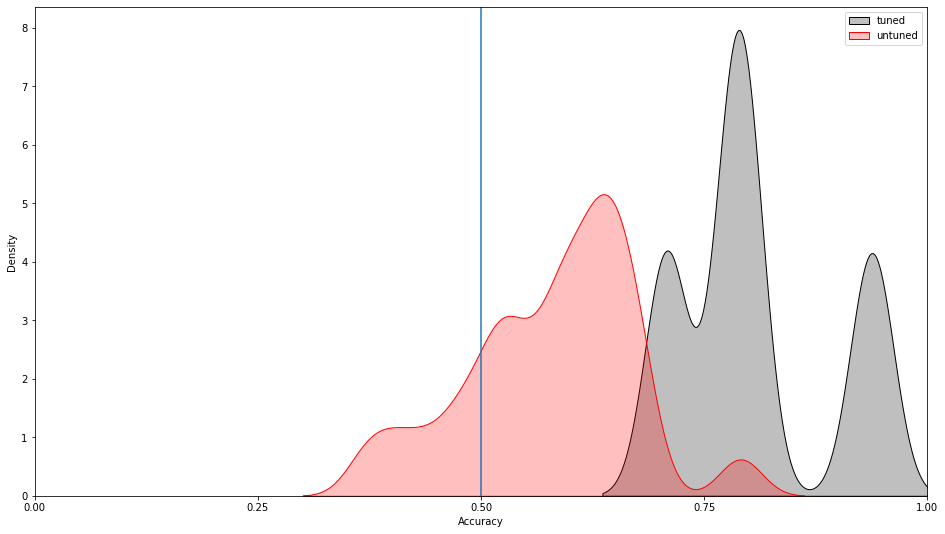

In [12]:
# plot histogram of accuracy for tuned vs non-tuned units
import seaborn as sns
f, ax = plt.subplots(1, 1, figsize=(16, 9))

tuned_accuracies = [r["accuracy"] for r in results.values() if r["tuned"]]
untuned_accuracies = [r["accuracy"] for r in results.values() if not r["tuned"]]

# ax.hist(tuned_accuracies, density=True, bins=10, alpha=.5, color="k", label="tuned")
# ax.hist(untuned_accuracies, density=True, bins=10, alpha=.5, color="red", label="untuned")

sns.kdeplot(tuned_accuracies, shade=True, ax=ax, color="k", bw_method=.25, label="tuned")
sns.kdeplot(untuned_accuracies, shade=True, ax=ax, color="red", bw_method=.25, label="untuned")


ax.axvline(.5)
ax.set(xlim=[0, 1], xlabel="Accuracy", ylabel="Density", xticks=[0, .25, .5, .75, 1])
_ = ax.legend()

f.savefig(save_folder / f"LR_decoding_{TARGET}_accuracy_tunedvsuntuned_KDE.svg")


# Plot example unit

Plot firing rate over position for an example tuned unit

In [ ]:
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d

def upsample_frames_to_ms(var):
    """
        Interpolates the values of a variable expressed in frams (60 fps)
        to values expressed in milliseconds.
    """
    t_60fps = np.arange(len(var)) / 60
    f = interpolate.interp1d(t_60fps, var)

    t_1000fps = np.arange(0, t_60fps[-1], step=1/1000)
    # t_200fps = np.arange(0, t_60fps[-1], step=1/200)
    interpolated_variable_values = f(t_1000fps)
    return interpolated_variable_values





def calc_firing_rate(spikes_train: np.ndarray, dt: int = 10):
    """
        Computes the firing rate given a spikes train (wether there is a spike or not at each ms).
        Using a gaussian kernel with standard deviation = dt/2 [dt is in ms]
    """
    return gaussian_filter1d(spikes_train, dt)  * 1000




from mpl_toolkits.axes_grid1 import make_axes_locatable


def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(cbar_label)
    return cbar


# Compute firing rate through each curve for ech ROI and plot some examples

In [ ]:
UNIT_ID = 10


# sort units based on accuracy
sorted_units = sorted(results.values(), key=lambda x: x["accuracy"], reverse=True)

best_unit = sorted_units[UNIT_ID]
rec, unit = best_unit["identifier"].split("+")

# load rec
units, left_fl, right_fl, left_hl, right_hl, body = alldata[rec]
out_bouts = get_session_bouts(rec, complete=None)
in_bouts = get_session_bouts(rec, direction="inbound", complete=None)

out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

# get unit data
unit = units.loc[units.unit_id == int(unit.split("_")[-1])].iloc[0]

CURVES = ("first", "second", "third", "fourth")
firing_rate_data = {
    "left":{curv : dict(x=[], y=[], frate=[]) for curv in CURVES},
    "right":{curv : dict(x=[], y=[], frate=[]) for curv in CURVES},
}

for i, curve in enumerate(CURVES):
    crossings_out = out_crossings[curve]
    crossings_in = in_crossings[curve]

    for c, crossings in enumerate([crossings_out, crossings_in]):
        for _, cross in crossings.iterrows():
            bout = out_bouts.iloc[cross.bout_idx] if c  == 0 else in_bouts.iloc[cross.bout_idx]

            # get XY coord
            X = np.array(bout.x[cross.enter_frame:cross.exit_frame])
            Y = np.array(bout.y[cross.enter_frame:cross.exit_frame])

            # get spikes  & position in milliseconds
            spikes = unit.spikes[(unit.spikes > cross.session_start_frame)&(unit.spikes < cross.session_end_frame)] - cross.session_start_frame

            time_frames = np.zeros(int(cross.session_end_frame - cross.session_start_frame))
            time_frames[spikes.astype(np.int)] = 1

            spike_ms = upsample_frames_to_ms(time_frames)
            spike_ms[spike_ms < np.max(spike_ms)] = 0  # make sure it's binary
            x_ms = upsample_frames_to_ms(X)
            y_ms = upsample_frames_to_ms(Y)
            frate = calc_firing_rate(spike_ms, dt=200)

            # store data
            side = list(curve_direction[curve].values())[c]
            firing_rate_data[side][curve]["x"].extend(x_ms)
            firing_rate_data[side][curve]["y"].extend(y_ms)
            firing_rate_data[side][curve]["frate"].extend(frate)

plot an example unit

In [ ]:

x_shift = [15, 24, 15,  5, ]
y_shift = [0, 0,  0,  10,]

# get unit data
best_unit = sorted_units[10]
rec, unit = best_unit["identifier"].split("+")
units, left_fl, right_fl, left_hl, right_hl, body = alldata[rec]
unit = units.loc[units.unit_id == int(unit.split("_")[-1])].iloc[0]

# plot a heatmap of the firing rate at each curve in each direction
f, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

for ax in axes:
    ax.axis("equal")
    ax.axis("off")

vmax = [40, 40]

for i, side in enumerate(("left", "right")):
    cmap = "Reds" if i == 0 else "Blues"
    for j, curve in enumerate(CURVES):

        dx = x_shift[j] if i == 1 else 0
        dy = y_shift[j] if i == 1 else 0

        x = np.array(firing_rate_data[side][curve]["x"]) + dx
        y = np.array(firing_rate_data[side][curve]["y"]) + dy
        frate = np.array(firing_rate_data[side][curve]["frate"]) 
        
        # time_frames = np.zeros(int(cross.session_end_frame - cross.session_start_frame))
        # time_frames[spikes.astype(np.int)] = 1
        # spike_ms = upsample_frames_to_ms(time_frames)
        # frate = calc_firing_rate(spike_ms, dt=100) / 1000


        im = axes[j].hexbin(x, y, frate, cmap=cmap, gridsize=[10, 15], mincnt=50, vmin=0, vmax=vmax[i])

        # add colorbar
        if j == 0 and i == 0:
            add_colorbar(axes[0], im, "Firing rate (Hz)")

        if j == 1 and i == 1:
            add_colorbar(axes[2], im, "Firing rate (Hz)")


# save figure 
# f.savefig(f"{save_folder}/LR_decoding_example_{TARGET}_{unit.unit_id}_firing_rate.svg", dpi=300)

# Analyze differences in the kinematics

In [ ]:
curve_direction = dict(
    first=dict(out="right", _in="left"),
    second=dict(out="right", _in="left"),
    third=dict(out="left", _in="right"),
    fourth=dict(out="left", _in="right"),
)


speeds = {}

for rec in alldata.keys():
    print(f"Doing {rec}")
    out_bouts = get_session_bouts(rec, complete=None)
    in_bouts = get_session_bouts(rec, direction="inbound", complete=None)

    out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
    in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}
    
    rec_speed = dict(left=[], right=[])
    for i, curve in enumerate(("second", "third", "fourth")):
        crossings_out = out_crossings[curve]
        crossings_in = in_crossings[curve]

        for c, crossings in enumerate([crossings_out, crossings_in]):
            for _, cross in crossings.iterrows():
                bout = out_bouts.iloc[cross.bout_idx] if c  == 0 else in_bouts.iloc[cross.bout_idx]

                # get XY coord
                speed = np.array(bout.speed[cross.enter_frame:cross.exit_frame])
                side = list(curve_direction[curve].values())[c]
                rec_speed[side].extend(speed)
    speeds[rec] = rec_speed

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

for rec, s in speeds.items():
    ax.hist(s["left"], bins=np.arange(0, 60, 1), color="red", alpha=0.5)
    ax.hist(s["right"], bins=np.arange(0, 60, 1), color="black", alpha=0.5)



### Fit logistic on speed traces
Prep data first

In [ ]:

def bin_x_by_y(
    data: pd.DataFrame,
    x: str,
    y: str,
    bins: np.ndarray = 10,
    min_count: int = 0,
):
    """
        Bins the values in a column X of a dataframe by bins
        specified based on the values of another column Y
    """

    # get bins
    data["bins"], bins = pd.cut(data[y], bins=bins, retbins=True)
    data = data.loc[data.bins != np.nan]
    bins_centers = (
        bins[0] + np.cumsum(np.diff(bins)) - abs(np.diff(bins)[0] / 2)
    )

    # get values
    mu = data.groupby("bins")[x].mean()
    sigma = data.groupby("bins")[x].std()
    counts = data.groupby("bins")[x].count()

    return bins_centers, mu, sigma, counts


In [ ]:
curve_direction = dict(
    second=dict(out="right", _in="left"),
    third=dict(out="left", _in="right"),
    fourth=dict(out="left", _in="right"),
)


ds = 2
bins = np.arange(-20, 20+ds, step=ds)


data = {
    **dict(
        name=[],  # recording name
        direction=[],  # direction (out/in)
        label=[],  # left, right or straight
        nunits = [],
    ),
    **{s:[] for s in bins[1:]}  # firing rate at each S position bin
}



for REC in get_recording_names(region=TARGET):
    # fetch recording data
    # units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    units, left_fl, right_fl, left_hl, right_hl, body = alldata[REC]

    if units is None or not len(units):
        continue
    
    if TARGET == "MOs":
        units = units.loc[units.brain_region.isin(["MOs", "MOs1", "MOs2/3", "MOs5", "MOs6a", "MOs6b"])]
    else:
        units = units.loc[units.brain_region.isin(["CUN", "PPN"])]
        

    out_bouts     = get_session_bouts(REC, complete=None)
    in_bouts      = get_session_bouts(REC, direction="inbound", complete=None)
    out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
    in_crossings  = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

    for curve in ("second", "third", "fourth"):
        for (direction, crossings, bouts) in (("out", out_crossings[curve], out_bouts), ("_in", in_crossings[curve], in_bouts)):
            sign = 1 if direction == "out" else -1

            for i, cross in crossings.iterrows():

                # get spikes at each bin
                bout = bouts.iloc[cross.bout_idx]
                s = sign * (curves[curve].s - np.array(bout.s[cross.enter_frame:cross.exit_frame]))

                # get binned speed
                speed = np.array(bout.speed[cross.enter_frame:cross.exit_frame])             
                _, binned_speed, _, _ = bin_x_by_y(
                    pd.DataFrame(dict(s=s, speed=speed)),
                    "speed", "s", bins=bins
                )

                # store all data
                data["name"].append(REC)
                data["direction"].append(direction)
                data["label"].append(curve_direction[curve][direction])
                data["nunits"].append(len(units))
                for i, bin in enumerate(bins[1:]):
                    data[bin].append(binned_speed[i])


data = pd.DataFrame(data)
data = data.join(pd.get_dummies(data[["label", "direction"]]))
data.head()

In [ ]:
PREDICTED = "label_right"
results, shuffled_accuracies = {}, []
select_cols = list(bins[1:]) + [PREDICTED]
units_explained_away_by_speed = 0
tot_units = 0
for rec in track(data['name'].unique()):
    # sample L/R trials to get equal number of trials per direction
    rec_data = data.loc[data['name'] == rec]
    name = rec_data.name.iloc[0]

    side_counts = rec_data.groupby(["label"])["name"].count()

    try:
        n_selected = min(side_counts["left"], side_counts["right"])
    except:
        continue
    
    if n_selected < 12:
        continue
    
    left = rec_data.loc[rec_data.label == "left"].sample(n_selected)
    right = rec_data.loc[rec_data.label == "right"].sample(n_selected)

    # keep bins + label column
    rec_data = pd.concat([left, right])[select_cols].reset_index(drop=True).dropna()

    # split train/test
    X = rec_data.drop(PREDICTED, axis=1)
    y = rec_data[PREDICTED]

    # standardize columns of X
    X = (X - X.mean()) / (X.std() + 0.0001)


    # fit the model with 5x k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    kf.get_n_splits(X)
    kf_accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fit model
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)
        kf_accuracies.append(logreg.score(X_test, y_test))


    # fit model on randomly shuffled labels
    # split X in train/test
    X_train, X_test, _, _ = train_test_split(X, y, test_size=.3, random_state=0)
    rec_shuffled_accuracies = []
    for i in range(100):
        y_shuffled = y.sample(frac=1, random_state=i)
        _, _, y_shuff_train, y_shuff_test = train_test_split(X, y_shuffled, test_size=0.3, random_state=0)

        shuffled_logreg = LogisticRegression()
        shuffled_logreg.fit(X_train, y_shuff_train)

        acc = shuffled_logreg.score(X_test, y_shuff_test)
        shuffled_accuracies.append(acc)
        rec_shuffled_accuracies.append(acc)

    # check if the model is significantly better than the shuffled labels
    tuned = np.mean(kf_accuracies) > np.percentile(rec_shuffled_accuracies, 99)


    n_units = data.loc[data['name'] == rec]["nunits"].iloc[0]
    tot_units += n_units
    if tuned:
        units_explained_away_by_speed += n_units

    results[rec] = dict(
        name=name,
        model=logreg,
        accuracy=np.mean(kf_accuracies),
        # scaler=scaler,
        tuned = tuned,
        X_test=X_test,
        y_test=y_test,

    )

    # if len(results.keys()) > 100:
    #     break

print(f"Succesfully fit {len(results.keys())} models")

In [ ]:
print(f"{units_explained_away_by_speed}/{tot_units} ({units_explained_away_by_speed/tot_units*100}) units explained away by speed")

In [ ]:
# get a list of which recordings are tuned
tuned_recs = [rec for rec, res in results.items() if res["tuned"]]
tuned_recs

In [ ]:
# Plot number of tuned units as bar plot
f, ax = plt.subplots(1, 1, figsize=(16, 9))

N = len(results.keys())
n_tuned = len([r for r in results.values() if r["tuned"]])

print(f"Fraction tuned: {n_tuned/N} - {n_tuned}/{N}")

ax.bar(0, n_tuned/N, color="k")
ax.bar(0, (N - n_tuned)/N, bottom=(n_tuned)/N, color=[.75, .75, .75])
_ = ax.set(xlim=[-2, 2], ylabel="Fraction tuned", xlabel=TARGET)
ax.axhline(.5)


f.savefig(save_folder / f"LR_decoding_{TARGET}_n_tuned_BEAHAV_ONLY.svg")

# Analyze speed tuning

Take low/high locomotion speed frames when the mouse is not turning and do a logistic regression to see if you can tell from neural activity. 

In [ ]:
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

def upsample_frames_to_ms(var):
    """
        Interpolates the values of a variable expressed in frams (60 fps)
        to values expressed in milliseconds.
    """
    t_60fps = np.arange(len(var)) / 60
    f = interpolate.interp1d(t_60fps, var)

    t_1000fps = np.arange(0, t_60fps[-1], step=1 / 1000)
    # t_200fps = np.arange(0, t_60fps[-1], step=1/200)
    interpolated_variable_values = f(t_1000fps)
    return interpolated_variable_values


In [122]:
regression_data = {}

for REC in get_recording_names(region=TARGET):
    # fetch recording data
    # units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    units, left_fl, right_fl, left_hl, right_hl, body = alldata[REC]
    
    # get tracking data
    recdata = pd.DataFrame({
        k: upsample_frames_to_ms(body[k]) for k in ("speed", "global_coord", "angular_velocity")
    })


    # get spike times of each unit
    for i, unit in units.iterrows():
        spikes = np.zeros_like(body.speed)
        spike_times = unit.spikes
        spike_times = spike_times[spike_times < len(spikes)]
        spikes[spike_times] = 1
        spikes = upsample_frames_to_ms(spikes)
        spikes[spikes < np.max(spikes)] = 0
        recdata[f"{unit['name']}_{unit.unit_id}"] = gaussian_filter1d(spikes, sigma=100) * 1000


    # keep only when not turning too much
    recdata = recdata.loc[
        (recdata.angular_velocity > -500) & (recdata.angular_velocity < 500) 
    ]

    # split between slow/fast
    slow = recdata.loc[(recdata.speed > 5)&(recdata.speed < 20)]
    fast = recdata.loc[recdata.speed > 40]
    n_samples = np.min([len(fast), len(slow)]) - 1

    if n_samples < 1000: continue
    slow = slow.sample(n_samples)
    fast = fast.sample(n_samples)

    slow["speed_class"] = "slow"
    fast["speed_class"] = "fast"

    data = pd.concat([slow, fast])
    data = data.join(pd.get_dummies(data["speed_class"]))
    regression_data[REC] = data


In [123]:
results = dict(
    tuned = [],
)
for rec, data in regression_data.items():
    print(f"Fitting {rec}")
    data = data.reset_index(drop=True).dropna()
    data = data.drop(['speed', 'global_coord', 'angular_velocity', 'speed_class', 'slow'], axis=1)

    # split train/test
    X = data.drop(["fast"], axis=1)
    y = data["fast"]

    # standardize columns of X
    X = (X - X.mean()) / (X.std() + 0.0001)

    for n, unit in enumerate(X.columns):
        # print(f"Fitting {n+1}/{len(X.columns)}")
        x = X[unit]

        # fit the model with 5x k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        kf.get_n_splits(x)
        kf_accuracies = []
        for train_index, test_index in kf.split(x):
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # fit model
            logreg = LogisticRegression()
            logreg.fit(X_train.values.reshape(-1, 1), y_train.values)
            kf_accuracies.append(logreg.score(X_test.values.reshape(-1, 1), y_test.values))


        # fit model on randomly shuffled labels
        # split X in train/test
        X_train, X_test, _, _ = train_test_split(x, y, test_size=.3, random_state=0)
        rec_shuffled_accuracies = []
        for i in range(100):
            y_shuffled = y.sample(frac=1, random_state=i)
            _, _, y_shuff_train, y_shuff_test = train_test_split(X, y_shuffled, test_size=0.3, random_state=0)

            shuffled_logreg = LogisticRegression()
            shuffled_logreg.fit(X_train.values.reshape(-1, 1), y_shuff_train.values)

            acc = shuffled_logreg.score(X_test.values.reshape(-1, 1), y_shuff_test.values)
            rec_shuffled_accuracies.append(acc)

        # check if the model is significantly better than the shuffled labels
        tuned = np.mean(kf_accuracies) > np.percentile(rec_shuffled_accuracies, 99)
        results["tuned"].append(tuned)




Fitting FC_210715_AAA1110750_r5_hairpin
Fitting FC_210716_AAA1110750_r6_hairpin
Fitting FC_210720_AAA1110750_hairpin
Fitting FC_210721_AAA1110750_hairpin
Fitting FC_210722_AAA1110750_hairpin
Fitting FC_211022_BAA110516_hairpin
Fitting FC_211027_BAA110516_hairpin
Fitting FC_211214_BAA110517_hairpin
Fitting FC_220114_BAA110517_hairpin
Fitting FC_210830_BAA1110281_hairpin
Fitting FC_210831_BAA1110281_hairpin
Fitting FC_210901_BAA1110281_hairpin
Fitting FC_210906_BAA1110281_hairpin


Fraction tuned: 0.7727272727272727 - 374/484


<Figure size 1152x648 with 1 Axes>

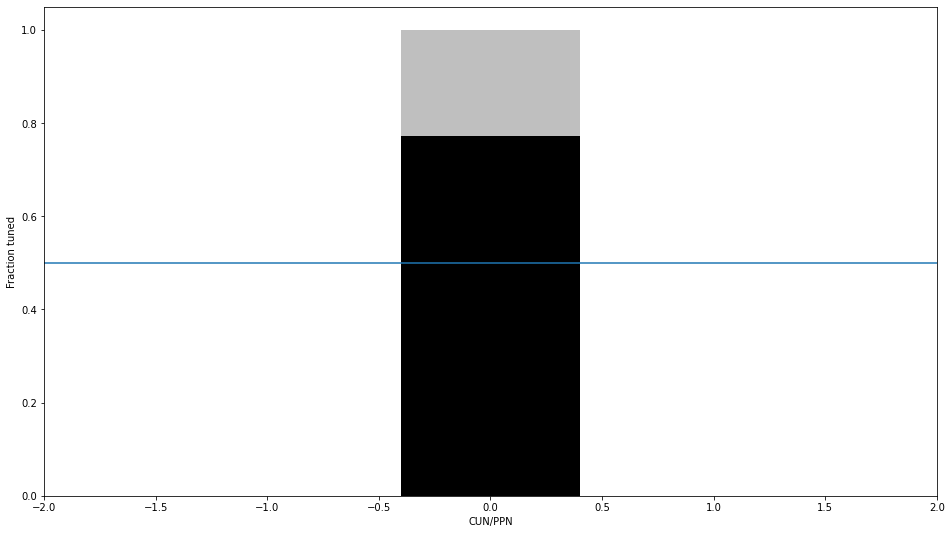

In [126]:
# plot the fraction of tuned units as a bar plot


# Plot number of tuned units as bar plot
f, ax = plt.subplots(1, 1, figsize=(16, 9))

N = len(results["tuned"])
n_tuned = sum(results["tuned"])

print(f"Fraction tuned: {n_tuned/N} - {n_tuned}/{N}")

ax.bar(0, n_tuned/N, color="k")
ax.bar(0, (N - n_tuned)/N, bottom=(n_tuned)/N, color=[.75, .75, .75])
_ = ax.set(xlim=[-2, 2], ylabel="Fraction tuned", xlabel=TARGET)
ax.axhline(.5)


f.savefig(save_folder / f"speed_decoding_{TARGET}_n_tuned.svg")